In [2]:
!wget ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index

--2020-05-21 13:24:19--  http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.197.77
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.197.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67069489 (64M) [application/octet-stream]
Saving to: ‘sequence.index’

sequence.index      100%[===================>]  63.96M   516KB/s    in 4m 11s  

2020-05-21 13:28:31 (261 KB/s) - ‘sequence.index’ saved [67069489/67069489]



In [7]:
import os 

from IPython.display import Image

import rpy2.robjects as robjects
import pandas as pd

from rpy2.robjects import pandas2ri
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter

In [8]:
read_delim = robjects.r('read.delim')
seq_data = read_delim('sequence.index', header=True, stringsAsFactors=False)

In [44]:
print('This data frame has %d columns and %d rows' % (seq_data.ncol, seq_data.nrow))
print(seq_data.colnames)
#In R:
#  print(colnames(seq.data))
#  print(nrow(seq.data))
#  print(ncol(seq.data))

print('Columns in Python %d ' % robjects.r.ncol(seq_data)[0])

#access some functions
as_integer = robjects.r('as.integer')
match = robjects.r.match

my_col = match('READ_COUNT', seq_data.colnames)[0] # Vector returned
print('Type of read count before as.integer: %s' % seq_data[my_col - 1].rclass[0])
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
print('Type of read count after as.integer: %s' % seq_data[my_col - 1].rclass[0])

my_col = match('BASE_COUNT', seq_data.colnames)[0] # Vector returned
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])

my_col = match('CENTER_NAME', seq_data.colnames)[0]
seq_data[my_col - 1] = robjects.r.toupper(seq_data[my_col - 1])
robjects.r.assign('seq.data', seq_data)
robjects.r('print(c("Column names in R: ",colnames(seq.data)))')

robjects.r('seq.data <- seq.data[seq.data$WITHDRAWN==0, ]')
#Lets remove all withdrawn sequences

robjects.r("seq.data <- seq.data[, c('STUDY_ID', 'STUDY_NAME', 'CENTER_NAME', 'SAMPLE_ID', 'SAMPLE_NAME', 'POPULATION', 'INSTRUMENT_PLATFORM', 'LIBRARY_LAYOUT', 'PAIRED_FASTQ', 'READ_COUNT', 'BASE_COUNT', 'ANALYSIS_GROUP')]")
#Lets shorten the dataframe

#Population as factor
robjects.r('seq.data$POPULATION <- as.factor(seq.data$POPULATION)')

This data frame has 26 columns and 187720 rows
 [1] "FASTQ_FILE"          "MD5"                 "RUN_ID"             
 [4] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [7] "SUBMISSION_ID"       "SUBMISSION_DATE"     "SAMPLE_ID"          
[10] "SAMPLE_NAME"         "POPULATION"          "EXPERIMENT_ID"      
[13] "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"    "LIBRARY_NAME"       
[16] "RUN_NAME"            "RUN_BLOCK_NAME"      "INSERT_SIZE"        
[19] "LIBRARY_LAYOUT"      "PAIRED_FASTQ"        "WITHDRAWN"          
[22] "WITHDRAWN_DATE"      "COMMENT"             "READ_COUNT"         
[25] "BASE_COUNT"          "ANALYSIS_GROUP"     

Columns in Python 26 
Type of read count before as.integer: RTYPES.INTSXP
Type of read count after as.integer: RTYPES.INTSXP
 [1] "Column names in R: " "FASTQ_FILE"          "MD5"                
 [4] "RUN_ID"              "STUDY_ID"            "STUDY_NAME"         
 [7] "CENTER_NAME"         "SUBMISSION_ID"       "SUBMISSION_DATE"  

YRI,YRI,YRI,...,STU,STU,STU


In [52]:
my_cols = robjects.r.ncol(seq_data)
print(my_cols)

[1] 26



In [47]:
import rpy2.robjects.lib.ggplot2 as ggplot2

In [48]:
from rpy2.robjects.functions import SignatureTranslatedFunction

ggplot2.theme = SignatureTranslatedFunction(ggplot2.theme, init_prm_translate = {'axis_text_x': 'axis.text.x'})

bar = ggplot2.ggplot(seq_data) + ggplot2.geom_bar() + ggplot2.aes_string(x='CENTER_NAME') + ggplot2.theme(axis_text_x=ggplot2.element_text(angle=90, hjust=1))
robjects.r.png('out.png', type='cairo-png')
bar.plot()
dev_off = robjects.r('dev.off')
dev_off()

1


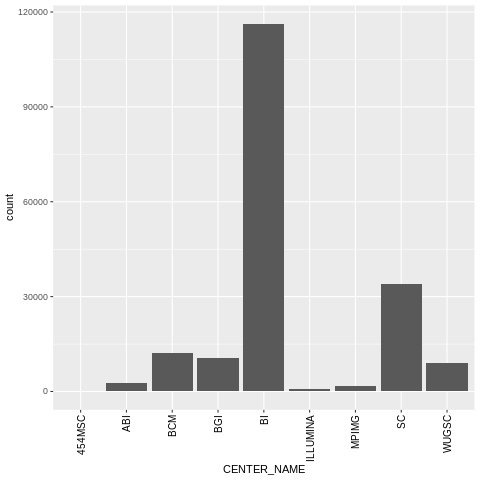

In [50]:
Image(filename='out.png')

In [55]:
#Get Yoruba and CEU
robjects.r('yri_ceu <- seq.data[seq.data$POPULATION %in% c("YRI", "CEU") & seq.data$BASE_COUNT < 2E9 & seq.data$READ_COUNT < 3E6, ]')
yri_ceu = robjects.r('yri_ceu')

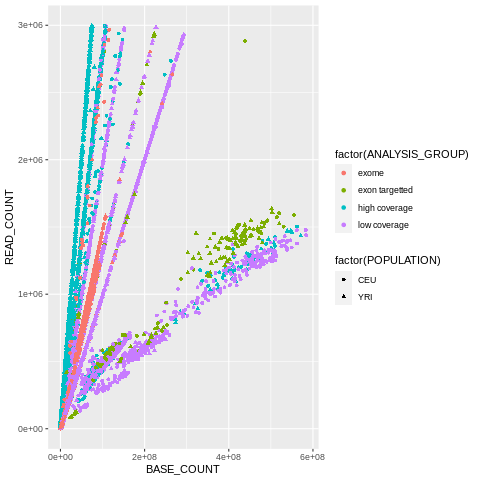

In [56]:
scatter = ggplot2.ggplot(yri_ceu) + ggplot2.aes_string(x='BASE_COUNT', y='READ_COUNT', shape='factor(POPULATION)', col='factor(ANALYSIS_GROUP)') + ggplot2.geom_point()
robjects.r.png('out.png')
scatter.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out.png')